# Deep Neural Network

In [1]:
import time
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
x_train = np.loadtxt("cat_train_x.csv", delimiter=",") / 255.0
y_train = np.loadtxt("cat_train_y.csv", delimiter=",").reshape(1, x_train.shape[1])
x_test = np.loadtxt("cat_test_x.csv", delimiter=",") / 255.0
y_test = np.loadtxt("cat_test_y.csv", delimiter=",").reshape(1, x_test.shape[1])

print(f"Shape of x_train : {x_train.shape}")
print(f"Shape of y_train : {y_train.shape}")
print(f"Shape of x_test : {x_test.shape}")
print(f"Shape of y_test : {y_test.shape}")

Shape of x_train : (12288, 209)
Shape of y_train : (1, 209)
Shape of x_test : (12288, 50)
Shape of y_test : (1, 50)


This is Cat


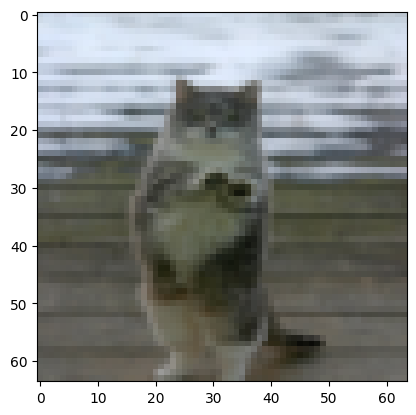

In [3]:
index = random.randrange(0, x_train.shape[1])
result = "Cat" if y_train[0][index] == 1 else "not a cat"
print(f"This is {result}")
plt.imshow(x_train[:,index].reshape(64, 64, 3))
plt.show()

---
# Activation Functions

In [4]:
def sigmoid(z):
    return (1 / (1 + np.exp(-z)))

def softmax(z):
    expZ = np.exp(z)
    return (expZ / np.sum(expZ, 0))

def relu(z):
    return np.maximum(0, z)

def tanh(x):
    return np.tanh(x)

def derivative_relu(x):
    return np.array(x > 0, dtype='float')

def derivative_tanh(x):
    return (1 - np.power(x, 2))

---
# Initialize Parameters

In [5]:
def initialize_params(layers_dimentions):

    Ls = len(layers_dimentions) - 1
    parameters = {}
    
    for layer_number in range(1, Ls + 1):
        # Trying to compress the initial random weight value to avoid VANISHING GRADIENT PROBLEM
        parameters['w' + str(layer_number)] = np.random.randn(layers_dimentions[layer_number], layers_dimentions[layer_number - 1]) / np.sqrt(layers_dimentions[layer_number])   
        parameters['b' + str(layer_number)] = np.zeros((layers_dimentions[layer_number], 1))

    return parameters

In [6]:
layers_dim = [x_train.shape[0], 100, 200, y_train.shape[0]]
params = initialize_params(layers_dim)

for l in range(1, len(layers_dim)):
    print(f"Shape of W{l} is {params['w' + str(l)].shape}")
    print(f"Shape of B{l} is {params['b' + str(l)].shape}\n")

Shape of W1 is (100, 12288)
Shape of B1 is (100, 1)

Shape of W2 is (200, 100)
Shape of B2 is (200, 1)

Shape of W3 is (1, 200)
Shape of B3 is (1, 1)



---
# Forward Propagation
- **sigmoid activation function will be used only at the last layer (output layer), while we will use relu/tanh for other layers**
- **For f(x), you can use either tanh or ReLU activation function. But also use the derivative of the same for Backpropagation as well** 

![Forward_Propogation](forward_prop.png)

$ \textcolor{red}{\text{👉 From first to last hidden layer (1 to (L - 1)), process will be repeat }} $
$ \textcolor{red}{\text{👉 For output layer (L), activation function will be used based on number of outputs}} $

In [31]:
def forward_propagation(X, params, activation='relu'):
    forward_cache = {}
    forward_cache['A0'] = X
    Ls = len(params) // 2
    
    # For all hidden layers....
    for l in range(1, Ls):
        forward_cache['Z' + str(l)] = params['w' + str(l)].dot(forward_cache['A' + str(l - 1)]) + params['b' + str(l)] 
        if activation == 'relu':
            forward_cache['A' + str(l)] = relu(forward_cache['Z' + str(l)])
        else :
            forward_cache['A' + str(l)] = tanh(forward_cache['Z' + str(l)])

    # For last output layer....
    forward_cache['Z' + str(Ls)] = params['w' + str(Ls)].dot(forward_cache['A' + str(Ls - 1)]) + params['b' + str(Ls)] 
    if forward_cache['Z' + str(Ls)].shape[0] == 1:
        forward_cache['A' + str(Ls)] = sigmoid(forward_cache['Z' + str(Ls)])
    else:
        forward_cache['A' + str(Ls)] = softmax(forward_cache['Z' + str(Ls)])
    
    return forward_cache['A' + str(Ls)], forward_cache

In [33]:
a_of_last_layer, cache = forward_propagation(x_train, params)

In [9]:
for label, value in cache.items():
    print(f"{label} : {value.shape}")
    print() if label.startswith('A') else ""

A0 : (12288, 209)

Z1 : (100, 209)
A1 : (100, 209)

Z2 : (200, 209)
A2 : (200, 209)

Z3 : (1, 209)
A3 : (1, 209)



---
# Cost Function

#### For binary classification:
$ Cost = - \frac{1}{m} \sum_{i=1}^{m} [ y*log(a_L) + (1-y)*log(1 - a_L) ] $

#### For multi-class classification:

$ Cost = - \frac{1}{m} \sum_{i=1}^{m} \sum_{i=k}^{n}[ y_k*log(a_k) ]$

In [38]:
def compute_cost(aL, Y):
    m = Y.shape[1]

    if Y.shape[0] == 1:
        cost = -(1 / m) * np.sum(Y * np.log(aL) + (1 - Y) * np.log(1 - aL)) # Element wise multiplication

    else:
        cost = -(1 / m) * np.sum(Y * np.log(aL))

    cost = np.squeeze(cost) # Extracts the value-only from the multi-dimention array

    return cost

---
# Backward Propagation

- For last layer, **$dZ_L$** will be $A_L - Y$
- Except for last layer, we use a loop to implement backprop for other layers

![Backward_Propogation](backward_prop.png)

In [18]:
def backward_propagation(aL, Y, params, forward_cache, activation='relu'):
    gradients = {}
    Ls = len(params) // 2
    m = Y.shape[1]

    # For last output layer....
    gradients["dZ" + str(Ls)] = aL - Y
    gradients["dW" + str(Ls)] = (1 / m) * np.dot(gradients["dZ" + str(Ls)], forward_cache["A" + str(Ls - 1)].T)
    gradients["dB" + str(Ls)] = (1 / m) * np.sum(gradients["dZ" + str(Ls)], axis=1, keepdims=True)

    for l in reversed(range(1, Ls)):
        
        if activation == 'relu':
            gradients["dZ" + str(l)] = np.dot(params["w" + str(l + 1)].T, gradients["dZ" + str(l + 1)]) * derivative_relu(forward_cache["A" + str(l)]) # f(Z) = A
        else:
            gradients["dZ" + str(l)] = np.dot(params["w" + str(l + 1)].T, gradients["dZ" + str(l + 1)]) * derivative_tanh(forward_cache["A" + str(l)]) # f(Z) = A
        
        gradients["dW" + str(l)] = (1 / m) * np.dot(gradients["dZ" + str(l)], forward_cache["A" + str(l - 1)].T)
        gradients["dB" + str(l)] = (1 / m) * np.sum(gradients["dZ" + str(l)], axis=1, keepdims=True)

    return gradients

In [19]:
grad = backward_propagation(cache["A" + str(3)], y_train, params, cache, 'tanh')

In [22]:
for label, values in grad.items():
    print(f"{label} : {values.shape}")
    print() if label.startswith("dB") else ""

dZ3 : (1, 209)
dW3 : (1, 200)
dB3 : (1, 1)

dZ2 : (200, 209)
dW2 : (200, 100)
dB2 : (200, 1)

dZ1 : (100, 209)
dW1 : (100, 12288)
dB1 : (100, 1)



---
# Update Parameters

![Update_Params](update_params.png)

In [23]:
def update_parameters(params, gradients, alpha):
    Ls = len(params) // 2
    
    for l in range(1, Ls + 1):
        params["w" + str(l)] = params["w" + str(l)] - alpha * gradients["dW" + str(l)]
        params["b" + str(l)] = params["b" + str(l)] - alpha * gradients["dB" + str(l)]

    return params

---
# Model

#### We need to initialize parameters once, and after that, we will run the following in a loop:
- **forward_prop(x, parameters)**
- **cost_function(aL, y)**
- **backward_prop(x, y, parameters, forward_cache)**
- **parameters = update_parameters(parameters, gradients, learning_rate)**

### Return :
- **parameters, which will be our trained parameters**

In [82]:
def accuracy(X, Y, params, activation='relu'):
    predictions, _ = forward_propagation(X, params, activation)

    if Y.shape[0] == 1:
        predictions = np.array(predictions > 0.5, dtype='float')
    else:
        Y = np.argmax(Y, axis=0)
        predictions = np.argmax(predictions, axis=0)

    return np.round(np.sum(Y == predictions) / Y.shape[1], 2)

In [117]:
def model(X, Y, layer_dims, alpha, activation='relu', iterations=100):
    params = initialize_params(layer_dims)
    cost_history = []
    
    for i in range(0, iterations):
        aL, cache = forward_propagation(X, params, activation)
        cost = compute_cost(aL, Y)
        gradients = backward_propagation(aL, Y, params, cache, activation)
        params = update_parameters(params, gradients, alpha)
        
        cost_history.append(cost)
        
        if i % (iterations / 10) == 0:
            print(f"\n{i} iterations,\t Cost : {cost:.4f},\t Training accuracy : {(accuracy(X, Y, params, activation) * 100):.2f} %,\t Test accuracy : {(accuracy(x_test, y_test, params, activation) * 100):.2f} %")

        if i % ((iterations / 10) / 10) == 0:
            print("===========", end='')
    return (params, cost_history)

In [119]:
layer_dimentions = [x_train.shape[0], 20, 10, 5, y_train.shape[0]]
learning_rate = 0.0075
iterations = 1000
activation_method = 'tenh'

params, cost_history = model(
    X = x_train,
    Y = y_train,
    layer_dims = layer_dimentions,
    alpha = learning_rate,
    activation = activation_method,
    iterations = iterations
)


0 iterations,	 Cost : 1.3876,	 Training accuracy : 38.00 %,	 Test accuracy : 54.00 %
100 iterations,	 Cost : 0.5908,	 Training accuracy : 70.00 %,	 Test accuracy : 46.00 %
200 iterations,	 Cost : 0.5396,	 Training accuracy : 72.00 %,	 Test accuracy : 46.00 %
300 iterations,	 Cost : 0.4965,	 Training accuracy : 76.00 %,	 Test accuracy : 44.00 %
400 iterations,	 Cost : 0.4626,	 Training accuracy : 77.00 %,	 Test accuracy : 38.00 %
500 iterations,	 Cost : 0.4353,	 Training accuracy : 80.00 %,	 Test accuracy : 42.00 %
600 iterations,	 Cost : 0.4112,	 Training accuracy : 83.00 %,	 Test accuracy : 42.00 %
700 iterations,	 Cost : 0.3896,	 Training accuracy : 84.00 %,	 Test accuracy : 42.00 %
800 iterations,	 Cost : 0.3694,	 Training accuracy : 86.00 %,	 Test accuracy : 40.00 %
900 iterations,	 Cost : 0.3467,	 Training accuracy : 87.00 %,	 Test accuracy : 40.00 %

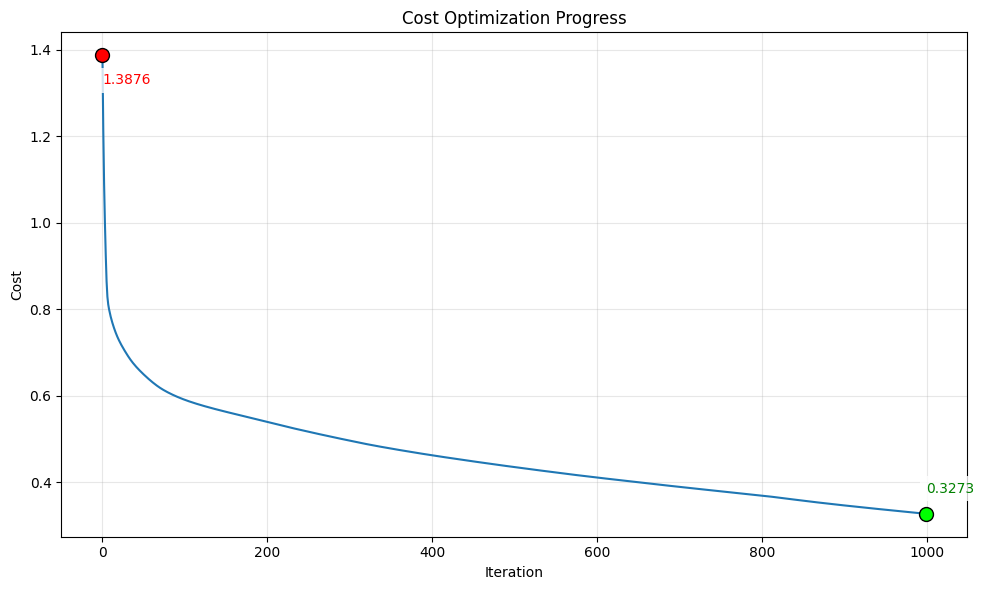

In [120]:
cost_history = np.array(cost_history)
min_cost, max_cost = np.nanmin(cost_history), np.nanmax(cost_history)
min_idx, max_idx = np.where(cost_history == min_cost)[0][0], np.where(cost_history == max_cost)[0][0]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(len(cost_history)), cost_history, label="Cost")

# Plot points
plt.scatter(min_idx, min_cost, color='lime', s=100, edgecolor='black', zorder=3)
plt.scatter(max_idx, max_cost, color='red', s=100, edgecolor='black', zorder=3)

# Fixed smart label positioning
def smart_label_pos(x, y, y_min, y_max):
    offset = (y_max - y_min) * 0.05  # 5% of plot height
    if y > (y_min + y_max)/2:  # Upper half
        return (x, y - offset)  # Place below
    else:
        return (x, y + offset)  # Place above

# Get y-axis limits
y_min, y_max = plt.ylim()
label_min_pos = smart_label_pos(min_idx, min_cost, y_min, y_max)
label_max_pos = smart_label_pos(max_idx, max_cost, y_min, y_max)

# Add labels
plt.text(*label_min_pos, f'{min_cost:.4f}', 
         ha='left', va='center', color='green', fontsize=10,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

plt.text(*label_max_pos, f'{max_cost:.4f}', 
         ha='left', va='center', color='red', fontsize=10,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

# Styling
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Cost Optimization Progress")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
# ReLu
- **At `1000` iterations with `0.0075` learning rate. cost is : `0.2963`**
- **At `1000` iterations with `0.02` learning rate. cost is : `0.0260`**

# tanh
- **At `1000` iterations with `0.0075` learning rate. cost is : `0.3520`**
- **At `1000` iterations with `0.02` learning rate. cost is : `0.1533`**